# Imports

In [277]:
import torch
import pytorch_lightning as pl
import tensorboard as tb
import json
import time
import warnings
from torch import nn
from pytorch_lightning.accelerators import *
from torch.utils.tensorboard import SummaryWriter
from lightning.pytorch.accelerators import find_usable_cuda_devices
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, DeepAR
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dataloading_helpers import electricity_dataloader
from config import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pmdarima as Arima
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
import pandas as pd

# EDA

In the following we will take a short look into the electricity dataset.
To not create bias, we will just look at the train dataset.
Because the dataset is not too complex, we will mostly look at the distribution of the target value.

First you can see a small overview over the dataset in the following outputs. Because the dataset has already gone through the preprocessing, provided in the google paper, 
no missing values are present and the only step missing is standardizing and/or normalizing of the data.

The first distribution-plot leads to the assumption, that we have many small values and not that much big ones. 
After log-transformation, we can assume, that even thou we have very small and very big values, the target variable is still in a normal distribution.


In [83]:
# load dataset as pandas df, hint with underscore, that test/validation should not be used
train, _, _ = electricity_dataloader.create_electricity_dataframe_not_normalized()  
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1923536 entries, 17544 to 10460742
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   power_usage              float64
 1   time_idx                 int32  
 2   days_from_start          int64  
 3   categorical_id           object 
 4   date                     object 
 5   id                       object 
 6   hour                     int64  
 7   day                      int64  
 8   day_of_week              int64  
 9   month                    int64  
 10  hours_from_start         float64
 11  categorical_day_of_week  int64  
 12  categorical_hour         int64  
dtypes: float64(2), int32(1), int64(7), object(3)
memory usage: 198.1+ MB


In [84]:
# check for NaNs
train.isnull().sum().any()

False

In [16]:
train.head()

,power_usage,time_idx,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
17544,2.538071,26304,1096,MT_001,2014-01-01 00:00:00,MT_001,0,1,2,1,26304.0,2,0
17545,2.855330,26305,1096,MT_001,2014-01-01 01:00:00,MT_001,1,1,2,1,26305.0,2,1
17546,2.855330,26306,1096,MT_001,2014-01-01 02:00:00,MT_001,2,1,2,1,26306.0,2,2
17547,2.855330,26307,1096,MT_001,2014-01-01 03:00:00,MT_001,3,1,2,1,26307.0,2,3
17548,2.538071,26308,1096,MT_001,2014-01-01 04:00:00,MT_001,4,1,2,1,26308.0,2,4


C:\Users\Benedikt\anaconda_main\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


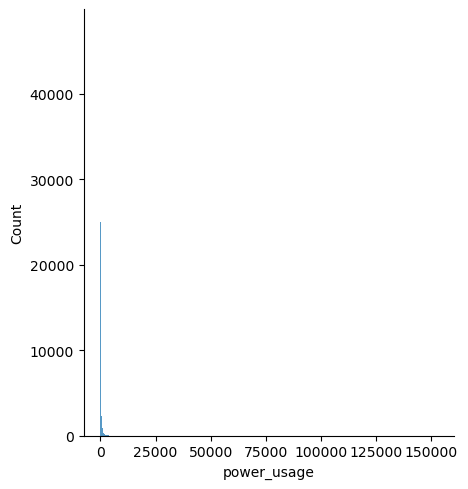

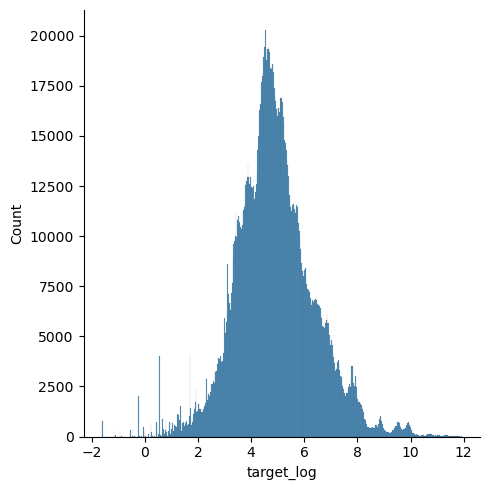

In [44]:
train["target_log"] = np.log(train['power_usage'])
target = sns.displot(data=train, x="power_usage", bins=20)
log_target = sns.displot(data=train, x="target_log")
plt.show()

There are 369 different ids present in the dataset. When looking at different ids and their mean and standard deviation, we can assume, that the normal distribution in the target variable is there due to different distribution for each id and not because each id represents the distribution of the target vairable. Therefore making id-specific normalization even more imporatant. 

In [47]:
train["categorical_id"].nunique()

369

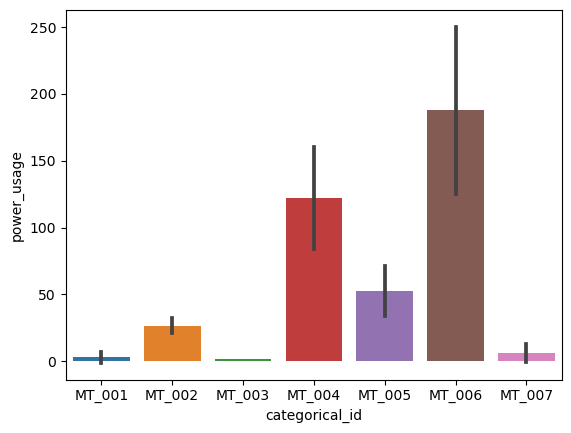

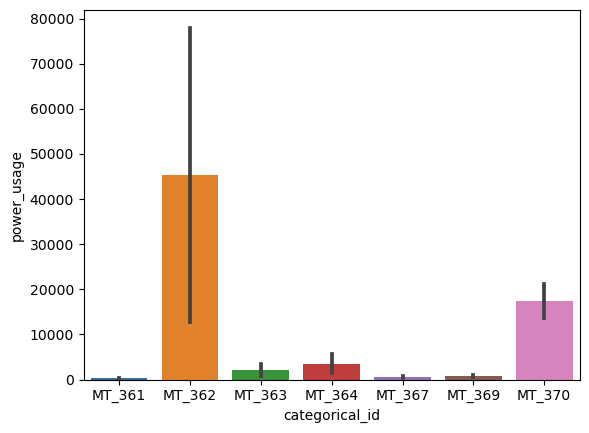

In [82]:
small_ids = ['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007']
big_ids =    ['MT_361', 'MT_362', 'MT_363', 'MT_364','MT_367', 'MT_369', 'MT_370']

small_train = train[train["categorical_id"].isin(small_ids)]
big_train = train[train["categorical_id"].isin(big_ids)]
        
def visualize_id_target(df):
    sns.barplot(x="categorical_id", y="power_usage", data=df, ci='sd')
    df.groupby(['categorical_id']).mean()['power_usage']
    df.groupby(['categorical_id']).std()['power_usage']
    plt.show()

visualize_id_target(small_train)
visualize_id_target(big_train)

# Baseline with ARIMA model

We will use the AutoRegressionIntegratedMovingAverage-model, to get a first understanding what performance can be expected with the electricity dataset.
For comparability, we use the same pre-processing as for the TFT and the NeuralProphete models.
ARIMA is not intendet to be a global model [1] and in the EDA part, we showed, that there is a big divergence between the different id-specific timeseries. 
Thus, the most sensible solution would be, to fit 369 ARIMA-models on the respective data to achieve more specific predictions.

Before starting off, we need to have a look at indicators on wheather a timeseries needs to be differenced to be stationary. Stationary meaning, that the
general strucure of the data does not change over time. Those could be the mean, standard deviation or auto-correlation.

Because auto-arima handles this automatically, this is just to get an idea, if all, some, or none of the timeseries needs to be differenced.

C:\Users\Benedikt\anaconda_main\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


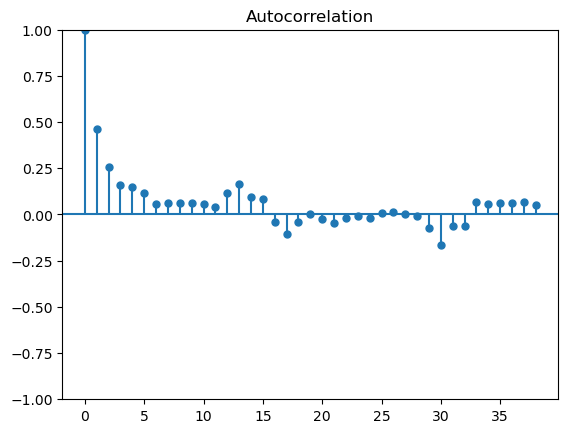

C:\Users\Benedikt\anaconda_main\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


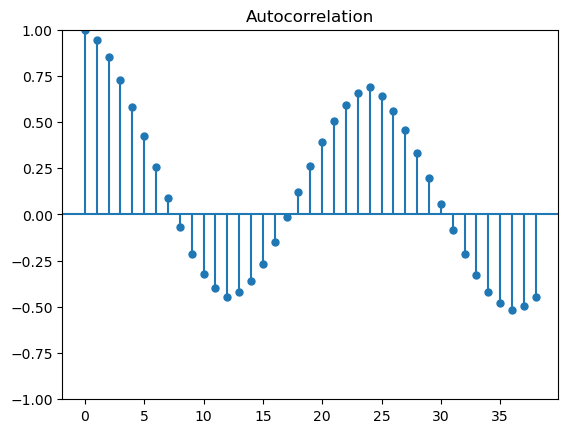

C:\Users\Benedikt\anaconda_main\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


This timeseries needs to be adjusted.


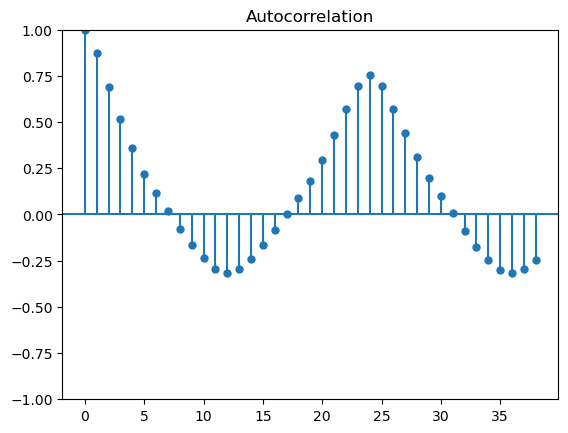

This timeseries needs to be adjusted.


In [94]:
train, _, _ = electricity_dataloader.create_electricity_timeseries_np()

x1 = train[train["categorical_id"] == "2"]["power_usage"].array
x2 = train[train["categorical_id"] == "150"]["power_usage"].array
x3 = train[train["categorical_id"] == "350"]["power_usage"].array

def eval_differenced(target_array):
    Arima.plot_acf(target_array)
    # Test whether we should difference at the alpha=0.05, significance level
    adf_test = ADFTest(alpha=0.05)
    p_val, should_diff = adf_test.should_diff(target_array)  # (0.01, False)

    # Estimate the number of differences using an ADF test:
    n_adf = ndiffs(target_array, test='adf')  # -> 0

    # Or a KPSS test (auto_arima default):
    n_kpss = ndiffs(target_array, test='kpss')  # -> 0

    # Or a PP test:
    n_pp = ndiffs(target_array, test='pp')  # -> 0
    if not n_adf == n_kpss == n_pp == 0 & should_diff == False:
        print("This timeseries needs to be adjusted.")
        
eval_differenced(x1)
eval_differenced(x2)
eval_differenced(x3)

As you can see, some timeseries are already stationary, some still need to be transformed. 
Now we will fit multiple ARIMA models on all timeseries. We have already learned from the TFT variable importance, that time of day is a more imporatant measure over all timeseries than day of week and month, thus we will give the auto-ARIMA the information, that we want to model seasonality over 24 timesteps, representing a full day. 

In [138]:
# Fit two different ARIMAs
m1 = Arima.auto_arima(train_split, error_action='ignore', seasonal=True, m=1)
m12 = Arima.auto_arima(train_split, error_action='ignore', seasonal=True, m=24)


fig, axes = plt.subplots(1, 2, figsize=(24, 8))
x = np.arange(test_split.shape[0])

# Plot m=1
axes[0].scatter(x, test_split, marker='x')
axes[0].plot(x, m1.predict(n_periods=test_split.shape[0]))
axes[0].set_title('Test samples vs. forecasts (m=1)')

# Plot m=12
axes[1].scatter(x, test_split, marker='x')
axes[1].plot(x, m12.predict(n_periods=test_split.shape[0]))
axes[1].set_title('Test samples vs. forecasts (m=24)')

plt.show()



ValueError: could not convert string to float: '2014-01-01 00:00:00'

C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


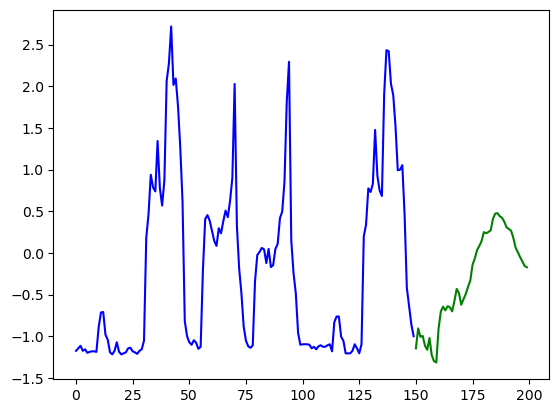

In [240]:
df, test, val = electricity_dataloader.create_electricity_timeseries_np()
df_array = df[df["categorical_id"] == "366"]

train_limit=150

df_array = df_array[:200]
train_split, test_split = train_test_split(df_array, train_size=train_limit)
                                          

# Fit your model
model = Arima.auto_arima(train_split[["power_usage"]], exogenous=train_split[['categorical_hour', "categorical_day_of_week", "time_idx"]], stepwise=True, seasonal=True, m=24)

# make your forecasts
forecasts, confidence = model.predict(test_split.shape[0], return_conf_int=True, exogenous=test_split[['categorical_hour', "categorical_day_of_week", "time_idx"]])  # predict N steps into the future

                                     

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(df_array.shape[0])
plt.plot(x[:train_limit], train_split["power_usage"].array, c='blue')
plt.plot(x[train_limit:], forecasts, c='green')
plt.show()

As a first trial, we are just using the test data. Fitting on all except for the last 24 timesteps and using those for evaluation of the models. 
Over the first 11 ids, we can observe a MAE of 0.349, which is a slightly worse performance than our best TFT with 0.329.

When fitting on the full train dataset, updating the model with the same input as used in the sanity checking, we get a comparable performance. 
Some models perform better, some worse.

Because we have to fit 369 models, letting each model look at all the possible data does not seem feasable with one fit taking around 30 minutes, leading to a potentiall training time of around a week.
As a first step we set the optimization steps to a maximum of 15, down from 50. This is recommended as a good trade off between time and performance in the documentation.
In case the training time is still the limiting factor, we will look into decreasing the size of training data.

Literature [2] is suggesting, that sometimes between 50 and 150 datapoints can already be enough. This number is supposed to be strongly linked to the number of datapoints per season. 
With our assumption of strong daily seasonality, this means we should look at a datasize some factor of 24. Because we are also using day of week as a variable, multiple weeks should be present,
leading us to a trainign input of 8 weeks, in cast the data reduction is still nessesary. 

To keep comparability in mind, we keep the same time horizon for predicting.  

In [279]:
# first sanity checking for iterating over all ids, building id-specific ARIMA models and evaluating all predictions
# for ease of use we are just utilizing the test_dataset, fitting on 720 timesteps and predicting on 24
import pandas as pd
train_data, test_data, val_data = electricity_dataloader.create_electricity_timeseries_np()

df = test_data
test_ids = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

global_preds = pd.Series()
global_y = pd.Series()

for i in test_ids:
    df_id = df[df["categorical_id"] == i]

    train_limit = (len(df_id)) - 24

    train_data, test_data = train_test_split(df_id, train_size=train_limit)


    y_test = test_data["power_usage"]
    y_train = train_data["power_usage"]

    x_test = test_data[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()
    x_train = train_data[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()


    # Fit your model
    model = Arima.auto_arima(y_train, exogenous=x_train, stepwise=True, seasonal=True, m=24)

    # make your forecasts
    forecasts, confidence = model.predict(x_test.shape[0], return_conf_int=True, exogenous=x_test)  # predict N steps into the future

    print(f"Mean absolute error: {mean_absolute_error(y_test, forecasts)}")
    
    global_preds = pd.concat([global_preds, forecasts], ignore_index=True)
    global_y = pd.concat([global_y, y_test], ignore_index=True)
    
print(f"Mean absolute error: {mean_absolute_error(global_y, global_preds)}")

"""
output: id 0 to 10
0.3388802756374581          0.3294981051251284
0.15282996514132505         0.27495762589728734
0.7044304854002063
0.17758196894376188
0.3299125277248563
0.29809827525213267
0.22203632396092277
0.34233352006608947
0.19240079028289495
0.763875613268234
0.32119806357267605

overall:
Mean absolute error: 0.3494161644773233

C:\Users\Benedikt\AppData\Local\Temp\ipykernel_28884\1898087278.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  global_preds = pd.Series()
C:\Users\Benedikt\AppData\Local\Temp\ipykernel_28884\1898087278.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  global_y = pd.Series()
C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.3388802756374581


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.15282996514132505


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.7044304854002063


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.17758196894376188


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.3299125277248563


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.29809827525213267


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.22203632396092277


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.34233352006608947


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.19240079028289495


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.763875613268234
Mean absolute error: 0.32119806357267605
Mean absolute error: 0.3494161644773233


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
import time
# load data
train_data, test_data, val_data = electricity_dataloader.create_electricity_timeseries_np()

test_ids = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
global_preds = pd.Series()
global_y = pd.Series()

for id_string in test_ids:
    start_time = time.time()
    
    # select one id, define x/y train dataframe and fit model
    train_data_id = train_data[train_data["categorical_id"] == id_string]
    train_data_id_y = train_data_id["power_usage"]
    train_data_id_x = train_data[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()

    model = Arima.auto_arima(train_data_id_y, exogenous=train_data_id_x, stepwise=True, seasonal=True, m=24, maxiter=15)


    # refit model on test_data and predict on last 24 timesteps
    test_data_id = test_data[test_data["categorical_id"] == id_string]
    train_limit = (len(test_data_id)) - 24
    test_data_id_update, test_data_id_predict = train_test_split(test_data_id, train_size=train_limit)

    test_data_id_update_y = test_data_id_update["power_usage"]
    test_data_id_predict_y = test_data_id_predict["power_usage"]

    test_data_id_update_x = test_data_id_update[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()
    test_data_id_predict_x = test_data_id_predict[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()

    model.update(test_data_id_update_y, test_data_id_update_x)


    # make your forecasts
    forecasts, confidence = model.predict(test_data_id_predict_y.shape[0], return_conf_int=True, exogenous=test_data_id_predict_x)
    
    global_preds = np.concatenate((global_preds, forecasts), axis=None)
    global_y = np.concatenate((global_y, test_data_id_predict_y), axis=None)
    
    print(f"Mean absolute error: {mean_absolute_error(test_data_id_predict_y, forecasts)}")
    
    end_time = time.time()
    print("This iteration took: ", (end_time-start_time)/60 )
    
print(f"Mean absolute error: {mean_absolute_error(global_preds, global_y)}")

C:\Users\Benedikt\AppData\Local\Temp\ipykernel_28884\3774317519.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  global_preds = pd.Series()
C:\Users\Benedikt\AppData\Local\Temp\ipykernel_28884\3774317519.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  global_y = pd.Series()


Mean absolute error: 0.3071338617747355
This iteration took:  41.18218485116959
Mean absolute error: 0.15531780823673913
This iteration took:  55.22337904771169
Mean absolute error: 0.7682150571514624
This iteration took:  23.155913643042247
Mean absolute error: 0.16246670268735633
This iteration took:  15.263390175501506
Mean absolute error: 0.25746037205458033
This iteration took:  26.75519381761551
Mean absolute error: 0.27158164310059857
This iteration took:  22.4262975692749
Mean absolute error: 0.07647012169082784
This iteration took:  19.41432597239812


C:\Users\Benedikt\anaconda_main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean absolute error: 0.32234153295604784
SMAPE: 51.74425980831324


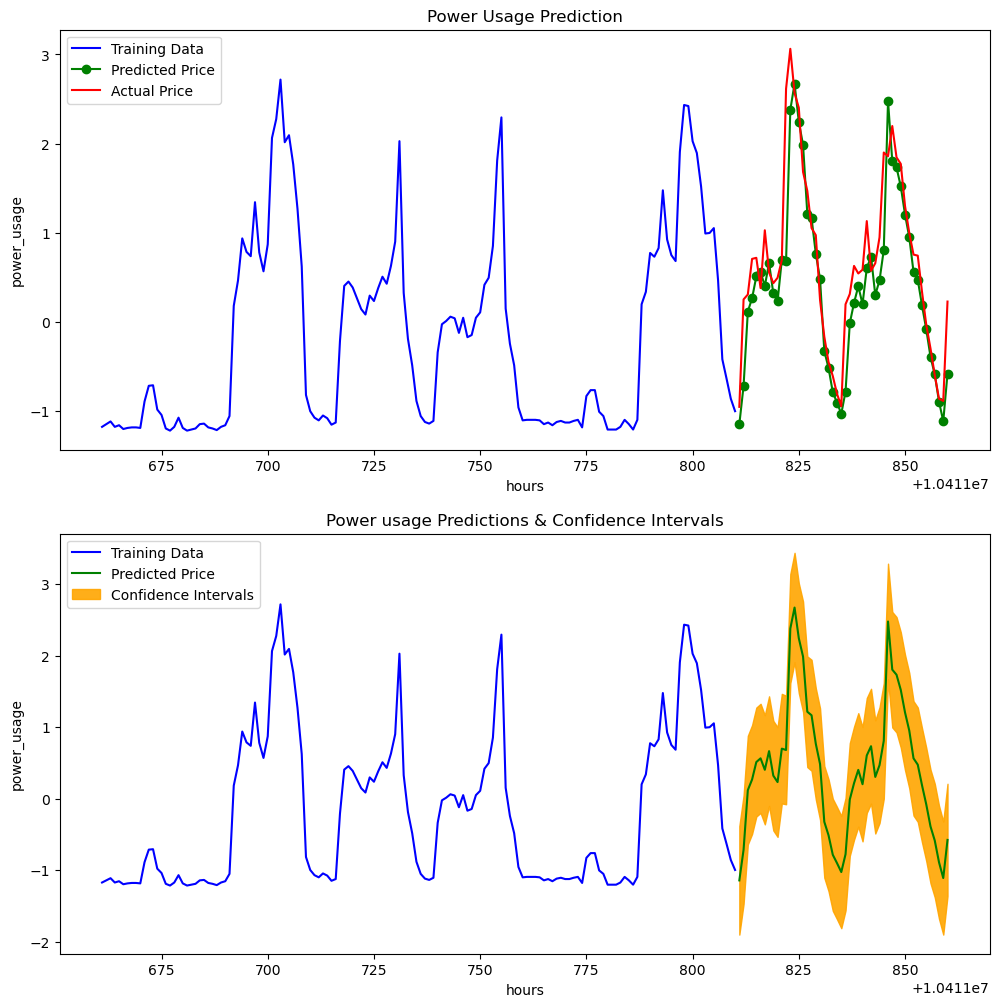

In [242]:
# visualize forecasts
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.metrics import smape

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True, exogenous=x_test)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])


forecasts = []
confidence_intervals = []

for i in y_test.index:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(y_test[i], x_test.loc[i, :].values.tolist())

print(f"Mean absolute error: {mean_absolute_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Consumption')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Power Usage Prediction')
axes[0].set_xlabel('hours')
axes[0].set_ylabel('power_usage')

axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Consumption')

axes[1].set_title('Power usage Predictions & Confidence Intervals')
axes[1].set_xlabel('hours')
axes[1].set_ylabel('power_usage')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()



This visualization gives us an idea, if the model does actually model what we want it to model. The question can be answered with a clear yes. 

# Evaluating TFT model using the electricity dataset

After we have run the hyperparameter optimization script and done a full training run with the TFT and the electricity dataset, we can load the model with the lowest validaiton loss into this notebook and have a closer look into our performance and explainability. We have to instantiate the trainer and model, before loading the training state.

In [16]:
# best parameters estimated by hypertuning and manually rounded
hyper_dict = {
              'gradient_clip_val': 0.052, 
              'hidden_size': 128, 
              'dropout': 0.15, 
              'hidden_continuous_size': 32, 
              'attention_head_size': 2, 
              'learning_rate': 0.007,
              }

if torch.cuda.is_available():
    accelerator = "gpu"
    devices = find_usable_cuda_devices(1)
else:
    accelerator = None
    devices = 'cpu'
     
# uncomment to read hyperparamter output from hyper-tuning script
#hyper_dict = pd.read_pickle(CONFIG_DICT["models"]["electricity"] / "tuning_logs" / "hypertuning_electricity.pkl")

# define callbacks, trainer and model, make sure to use save config as the trained model you want to load
checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath=CONFIG_DICT["models"]["electricity"] / "checkpoint_callback_logs",
    filename="sample-mnist-{epoch:02d}-{val_loss:.2f}",
    )

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor(logging_interval='epoch')  # log the learning rate
logger = TensorBoardLogger(CONFIG_DICT["models"]["electricity"])  # logging results to a tensorboard

trainer = pl.Trainer(
    default_root_dir=CONFIG_DICT["models"]["electricity"],
    max_epochs=10,
    #accelerator=accelerator,
    #devices=devices,
    enable_model_summary=True,
    gradient_clip_val=hyper_dict["gradient_clip_val"],
    #limit_train_batches=20, 
    fast_dev_run=False,  
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    log_every_n_steps=1,
    logger=logger,
    profiler="simple",
    )

tft = TemporalFusionTransformer.from_dataset(
    electricity["training_dataset"],
    learning_rate=hyper_dict["learning_rate"],
    hidden_size=hyper_dict["hidden_size"],
    attention_head_size=hyper_dict["attention_head_size"],
    dropout=hyper_dict["dropout"],
    hidden_continuous_size=hyper_dict["hidden_continuous_size"],
    output_size= 3,  
    loss=QuantileLoss([0.1, 0.5, 0.9]),
    log_interval=1,
    reduce_on_plateau_patience=2,
    optimizer="adam"
    )

tft.load_state_dict(torch.load(CONFIG_DICT["models"]["electricity"] / "tft_model"))

output = trainer.test(model=tft, dataloaders=electricity["test_dataloader"], ckpt_path=CONFIG_DICT["models"]["electricity"] / "checkpoint_callback_logs" / "sample-mnist-epoch=04-val_loss=0.22.ckpt")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_4\Information_Systems\TFT_project\RT1_TFT\models\electricity\checkpoint_callback_logs\sample-mnist-epoch=04-val_loss=0.22.ckpt
C:\Users\Benedikt\anaconda_main\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Loaded model weights from checkpoint at C:\Users\Benedikt\Desktop\Mein_Ordner\WI-INFO\Semester_4\Information_Systems\TFT_project\RT1_TFT\models\electricity\checkpoint_callback_logs\sample-mnist-epoch=04-val_loss=0.22.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MAE          │    0.3268718421459198     │
│         test_MAPE         │    1.6922143697738647     │
│         test_RMSE         │    0.47441667318344116    │
│        test_SMAPE         │    0.4973447620868683     │
│         test_loss         │    0.21136048436164856    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                              

After this short look at the model performance, let us look more closely at normalized P50 and P90 performance and explainability.
In the following you can see the most important variables for the Encoder, Decoder and the static variables.

After this we will give some visualization for the relationship between encoder-timesteps, decoder-timesteps and attention scores. 

Plotting instances Quantile distribution. 
Green: 96% 
Blue: 50% 
Red: Median


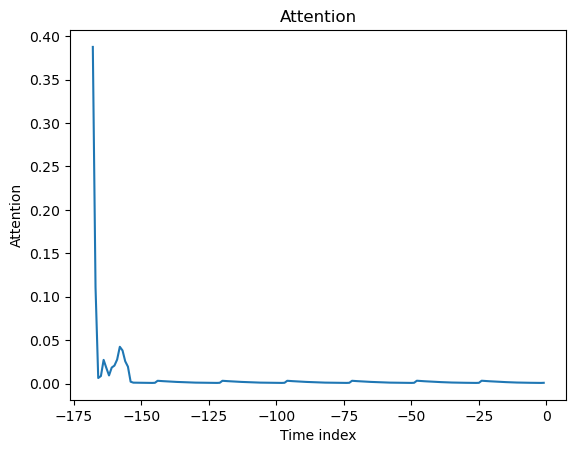

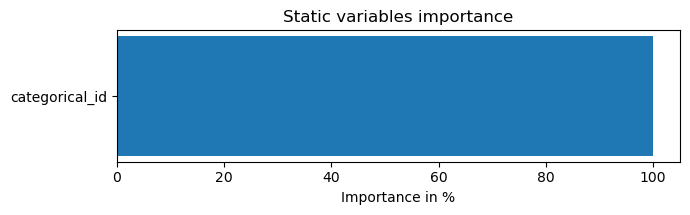

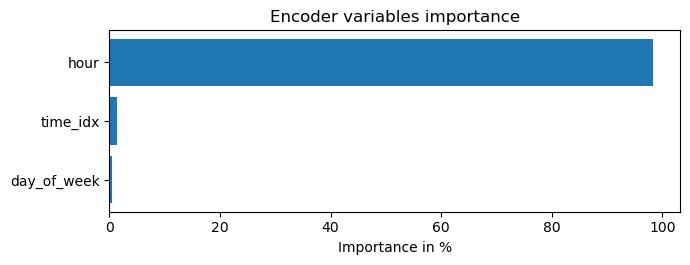

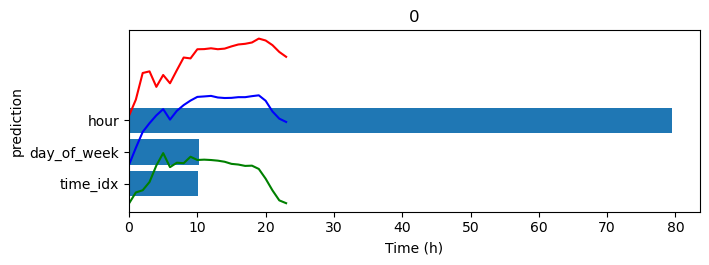

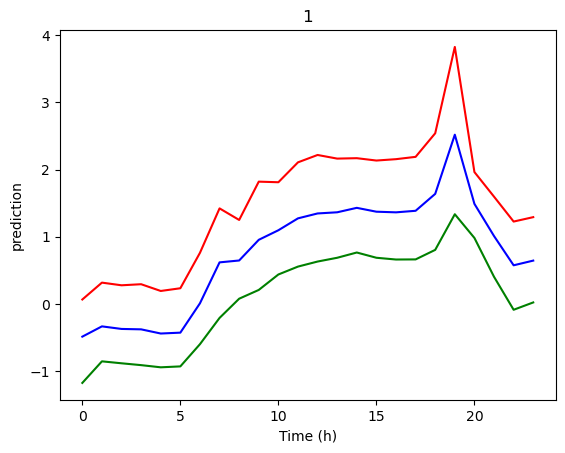

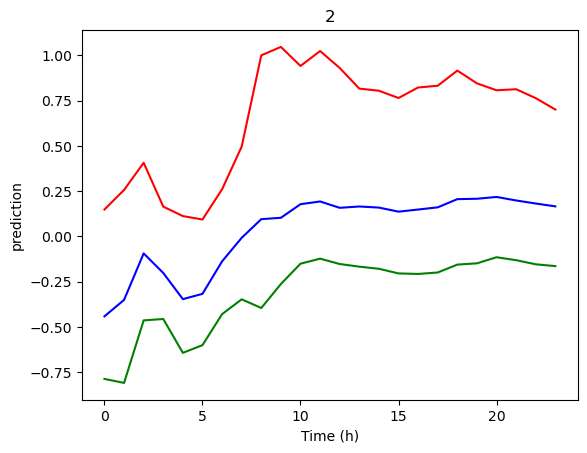

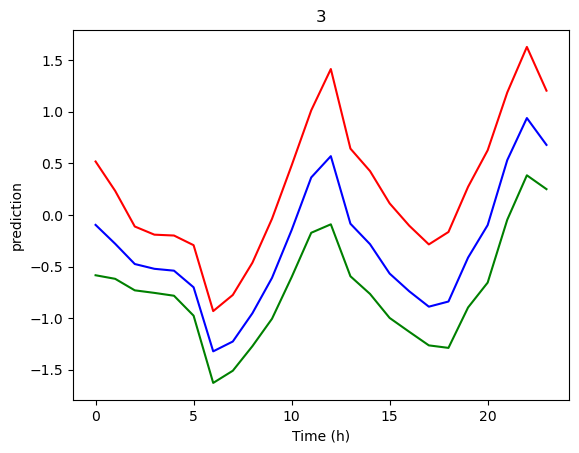

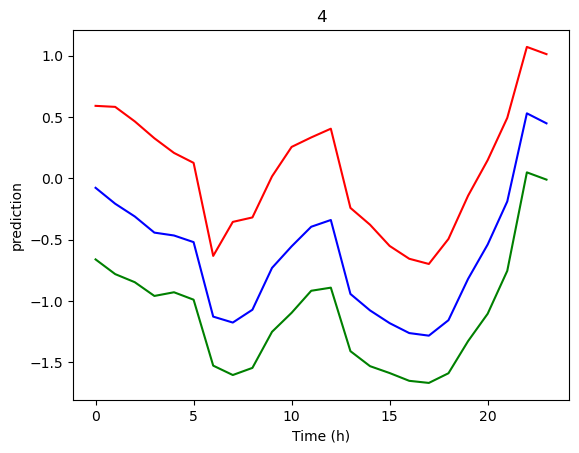

In [21]:
raw_predictions, x = tft.predict(timeseries_dict["test_dataloader"], mode="raw", return_x=True)

interpretation = tft.interpret_output(raw_predictions, reduction="sum")

tft.plot_interpretation(interpretation)

percentile_predictions, percentile_x = tft.predict(timeseries_dict["test_dataloader"], mode="quantiles", return_x=True)

def plot_quantile_prediction(percentile_prediction, idx):
    ypoints1 = percentile_predictions[idx,:,0]
    ypoints2 = percentile_predictions[idx,:,1]
    ypoints3 = percentile_predictions[idx,:,2]
    #ypoints4 = percentile_predictions[idx,:,4]
    #ypoints5 = percentile_predictions[idx,:,6]

    xpoints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

    plt.plot(xpoints, ypoints1, color="green")
    plt.plot(xpoints, ypoints2, color="blue")
    plt.plot(xpoints, ypoints3, color="red")
    #plt.plot(xpoints, ypoints4, color="blue")
    #plt.plot(xpoints, ypoints5, color="green")
    plt.xlabel("Time (h)")
    plt.ylabel("prediction")
    plt.title(idx)
    plt.show()


print("Plotting instances Quantile distribution. \nGreen: 96% \nBlue: 50% \nRed: Median")
for idx in range(5):
    plot_quantile_prediction(percentile_predictions, idx)

In [ ]:
def plot_quantile_prediction(percentile_prediction, idx):
    ypoints1 = percentile_predictions[idx,:,0]
    ypoints2 = percentile_predictions[idx,:,2]
    ypoints3 = percentile_predictions[idx,:,3]
    ypoints4 = percentile_predictions[idx,:,4]
    ypoints5 = percentile_predictions[idx,:,6]

    xpoints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

    plt.plot(xpoints, ypoints1, color="green")
    plt.plot(xpoints, ypoints2, color="blue")
    plt.plot(xpoints, ypoints3, color="red")
    plt.plot(xpoints, ypoints4, color="blue")
    plt.plot(xpoints, ypoints5, color="green")
    plt.xlabel("Time (h)")
    plt.ylabel("prediction")
    plt.title(idx)
    plt.show()

# evaluate
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(timeseries_dict["val_dataloader"])])
predictions = best_tft.predict(timeseries_dict["val_dataloader"])
print("Best model MAE: ",(actuals - predictions).abs().mean().item())


#tft.log_interpretation(predictions)


# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(timeseries_dict["val_dataloader"])])
baseline_predictions = Baseline().predict(timeseries_dict["val_dataloader"])
print("Baseline MAE: ",(actuals - baseline_predictions).abs().mean().item(), "\n\n")

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
print("Plotting attention, actuals and predictions:\n")
raw_predictions, x = best_tft.predict(timeseries_dict["val_dataloader"], mode="raw", return_x=True)
percentile_predictions, percentile_x = best_tft.predict(timeseries_dict["val_dataloader"], mode="quantiles", return_x=True)


for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

print("Plotting instances Quantile distribution. \nGreen: 96% \nBlue: 50% \nRed: Median")
for idx in range(5):
    plot_quantile_prediction(percentile_predictions, idx)

# Evaluating NeuralProphete using the electricity dataset

# References 

[1] S. Li, et al., Enhancing the locality and breaking the memory bottleneck of transformer on time series forecasting, in: NeurIPS, 2019.

[2] Box, G. E. P., and G. C. Tiao. 1975. Intervention analysis with applications to economic and environmental problems. Journal of the American Statistical Association 70: 70-79.